In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! [ ! -d "/content/dataset/UTKFace" ] && unzip "/content/drive/MyDrive/Datasets/utkface.zip" -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: dataset/utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.

In [3]:
dataset_folder_name = '/content/dataset/UTKFace'

IMG_WIDTH = IMG_HEIGHT = 200

In [4]:
import glob
import os
import random

filenames = glob.glob(os.path.join(dataset_folder_name, "*.%s" % 'jpg'))
random.shuffle(filenames)

In [5]:
from tensorflow.keras.utils import Sequence
import math
import numpy as np 
from PIL import Image

class UTKFaceSequence(Sequence):

    def __init__(self, filenames, batch_size, to_fit=True, shuffle=True):
        self.filenames = filenames
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.filenames) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle == True:
            random.shuffle(self.filenames)

    def __getitem__(self, idx):
        filenames = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        x_data = []
        y_data = []
        for filename in filenames:
            x, y = self.parse_info_from_file(filename)
            x_data.append(x)
            y_data.append(y)
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        return x_data, y_data
    
    def get_labels(self):
        labels = []
        for filename in self.filenames:
            filename = os.path.split(filename)[1]
            filename = os.path.splitext(filename)[0]
            gender = filename.split('_')[1]
            labels.append(int(gender))
        return labels

    @staticmethod
    def parse_info_from_file(img_path):
        img = Image.open(img_path)
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))

        # Normalization
        img = np.array(img) / 255.0

        filename = os.path.split(img_path)[1]
        filename = os.path.splitext(filename)[0]
        gender = float(filename.split('_')[1])

        return img, gender

# Defining CNN Model

In [6]:
import tensorflow as tf

leaky_relu_negative_slope = 0.2

inputs = tf.keras.layers.Input(shape = [IMG_WIDTH] + [IMG_HEIGHT] + [ 3 ])

x = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), strides=1, use_bias=False, 
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, use_bias=False,
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, use_bias=False,
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, use_bias=False,
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, use_bias=False,
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, use_bias=False,
                           kernel_initializer=tf.keras.initializers.HeNormal(), 
                           kernel_regularizer=tf.keras.regularizers.L2(1e-5))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(leaky_relu_negative_slope)(x)
x = tf.keras.layers.MaxPooling2D()(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.1), bias_regularizer=tf.keras.regularizers.L2(0.1))(x)
x = tf.keras.layers.LeakyReLU(alpha=leaky_relu_negative_slope)(x)
x = tf.keras.layers.Dropout(0.6)(x)

x = tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.L2(0.1), bias_regularizer=tf.keras.regularizers.L2(0.1))(x)
x = tf.keras.layers.LeakyReLU(alpha=leaky_relu_negative_slope)(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.L2(0.1), bias_regularizer=tf.keras.regularizers.L2(0.1))(x)
x = tf.keras.layers.LeakyReLU(alpha=leaky_relu_negative_slope)(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs, outputs)

model.summary()
# tf.keras.utils.plot_model( model , to_file='gender_model_architecture.png', show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 198, 198, 16)     64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 198, 198, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4608  

# Compiling the model

In [7]:
num_epochs = 50
batch_size = 128

filepath = 'saved_models/gender_recognition_{epoch:02d}_{val_binary_accuracy:.4f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, save_weights_only=False, monitor='val_binary_crossentropy')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=5, restore_best_weights=True)

model.compile( 
    loss=tf.keras.losses.binary_crossentropy, 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['binary_crossentropy', 'binary_accuracy'])

# Training the model

In [8]:
!rm -rf 'saved_models'
!rm -rf 'gender_recognition.h5'

TRAIN_TEST_SPLIT = 0.8
train_num_samples = int(len(filenames) * TRAIN_TEST_SPLIT)

train_data_generator = UTKFaceSequence(filenames[:train_num_samples], batch_size, shuffle=True)
test_data_generator = UTKFaceSequence(filenames[train_num_samples:], batch_size, shuffle=False)

history = model.fit( 
    x=train_data_generator,
    epochs=num_epochs,
    validation_data=test_data_generator, 
    callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/50
149/149 [==============================] - 56s 279ms/step - loss: 11.0958 - binary_crossentropy: 0.4853 - binary_accuracy: 0.7808 - val_loss: 1.4996 - val_binary_crossentropy: 0.5307 - val_binary_accuracy: 0.7442
Epoch 2/50
149/149 [==============================] - 40s 269ms/step - loss: 0.7375 - binary_crossentropy: 0.3319 - binary_accuracy: 0.8673 - val_loss: 0.5347 - val_binary_crossentropy: 0.3433 - val_binary_accuracy: 0.8560
Epoch 3/50
149/149 [==============================] - 40s 268ms/step - loss: 0.4286 - binary_crossentropy: 0.2780 - binary_accuracy: 0.8911 - val_loss: 0.4131 - val_binary_crossentropy: 0.2750 - val_binary_accuracy: 0.8783
Epoch 4/50
149/149 [==============================] - 41s 274ms/step - loss: 0.3705 - binary_crossentropy: 0.2416 - binary_accuracy: 0.9093 - val_loss: 0.3778 - val_binary_crossentropy: 0.2471 - val_binary_accuracy: 0.8941
Epoch 5/50
149/149 [==============================] - 40s 268ms/step - loss: 0.3351 - binary_crossentropy: 

# Saving the model

In [9]:
model.save('gender_recognition.h5')

# Evaluating the model




In [10]:
model = tf.keras.models.load_model('gender_recognition.h5')
model.evaluate(test_data_generator)

38/38 [==============================] - 8s 194ms/step - loss: 0.3395 - binary_crossentropy: 0.2220 - binary_accuracy: 0.9036


[0.3394632041454315, 0.2220408022403717, 0.9036271572113037]

# Visualization of the results

In [11]:
from sklearn.metrics import confusion_matrix

predicted = tf.keras.backend.greater_equal(model.predict(test_data_generator), 0.5)
actual = test_data_generator.get_labels()

cf_matrix = confusion_matrix(actual, predicted)
print(cf_matrix) 

[[2227  233]
 [ 224 2058]]


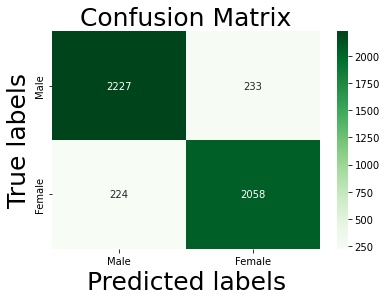

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax, cmap='Greens')

ax.set_xlabel('Predicted labels', {'size':'25'})
ax.set_ylabel('True labels', {'size':'25'})
ax.set_title('Confusion Matrix', {'size':'25'} )
ax.xaxis.set_ticklabels(['Male', 'Female'])
ax.yaxis.set_ticklabels(['Male', 'Female'])

plt.show()

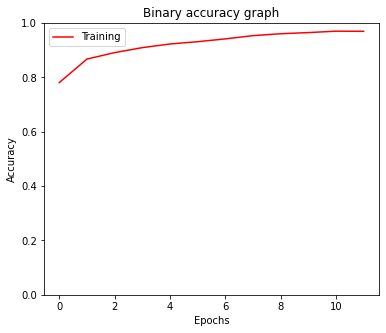

In [13]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['binary_accuracy'], color='r', label='Training')
# plt.plot(history.history['val_binary_accuracy'], color='g', label='Validation')

plt.title("Binary accuracy graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.ylim([0, 1])

plt.show()

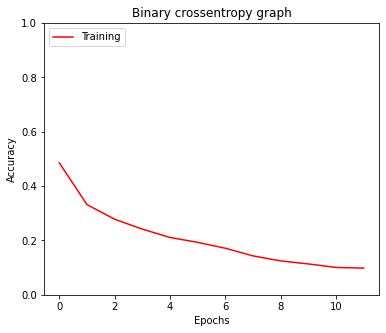

In [14]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['binary_crossentropy'], color='r', label='Training')
# plt.plot(history.history['val_binary_crossentropy'], color='g', label='Validation')

plt.title("Binary crossentropy graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.ylim([0, 1])

plt.show()

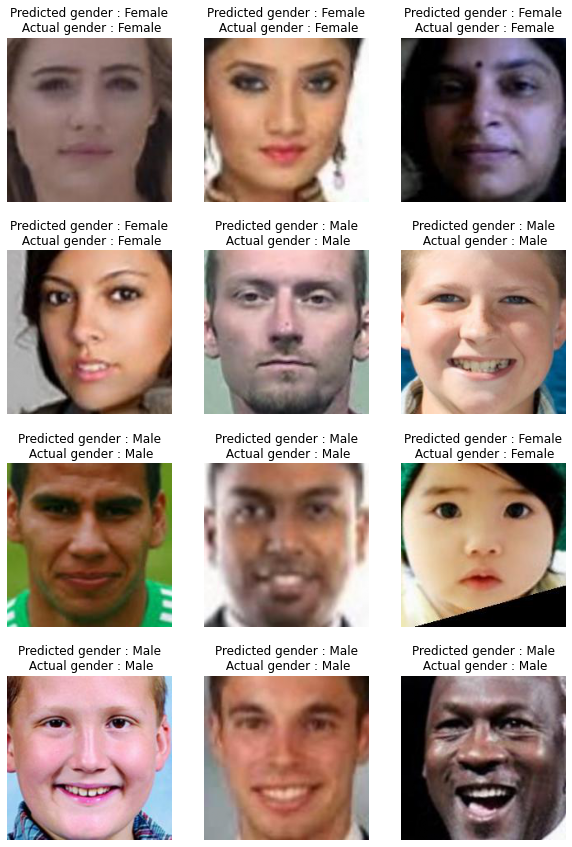

In [16]:
fig = plt.figure(figsize=(10 , 15))
x, y = test_data_generator.__getitem__(1)

genders_dict = {0 : "Male", 1 : "Female"}

for i, (image, label) in enumerate(zip(x[:12], y[:12])):
    fig.add_subplot(4, 3, i + 1)
    plt.imshow(image)
    prediction = int(tf.keras.backend.greater_equal(model.predict(np.expand_dims(image , 0)), 0.5))
    plt.axis('off')
    plt.title(f'Predicted gender : {genders_dict[prediction]}\n Actual gender : {genders_dict[int(label)]}')

plt.show()